CODE BLOCK FOR ENCRYPTION-DECRYPTION OF COLUMN DATA, BOTH USING STRATEGIES AS WELL AS RANDOM-SHUFFLING, WITH A FERNET KEY

Initial missing values:
T_LR              369
Total_load        369
HP_load           369
RH_LR             369
TotalOccupancy      0
dtype: int64

Remaining missing values after handling:
T_LR              0
Total_load        0
HP_load           0
RH_LR             0
TotalOccupancy    0
dtype: int64


<ipython-input-61-00d38c7f8c5a>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')



Original Data Correlation Matrix:
                    T_LR  Total_load   HP_load     RH_LR  TotalOccupancy
T_LR            1.000000    0.032178 -0.019848  0.578722        0.005192
Total_load      0.032178    1.000000  0.028002 -0.037174        0.243371
HP_load        -0.019848    0.028002  1.000000 -0.144962        0.028181
RH_LR           0.578722   -0.037174 -0.144962  1.000000        0.131377
TotalOccupancy  0.005192    0.243371  0.028181  0.131377        1.000000

Reconstructed Data Correlation Matrix:
                    T_LR  Total_load   HP_load     RH_LR  TotalOccupancy
T_LR            1.000000    0.032178 -0.019848  0.578722        0.005192
Total_load      0.032178    1.000000  0.028002 -0.037174        0.243371
HP_load        -0.019848    0.028002  1.000000 -0.144962        0.028181
RH_LR           0.578722   -0.037174 -0.144962  1.000000        0.131377
TotalOccupancy  0.005192    0.243371  0.028181  0.131377        1.000000

Verifying reconstruction

Data types comparison:

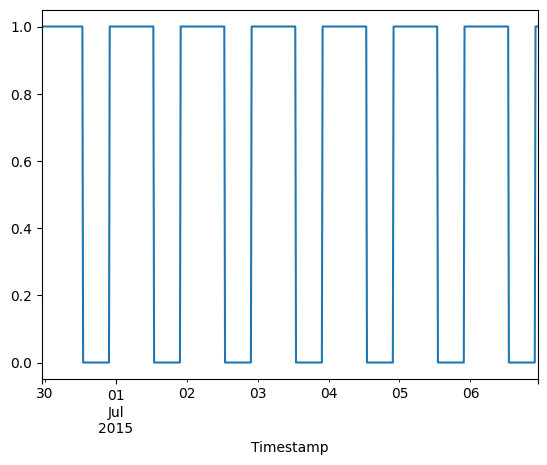

In [61]:
import pandas as pd
import numpy as np
import random
from cryptography.fernet import Fernet
import json
import base64
import matplotlib.pyplot as plt

def load_and_prepare_data(file_path):
    #Load and prepare data for missing value handling and for data cleaning
    try:
        df = pd.read_csv(file_path, parse_dates=['Timestamp'], index_col='Timestamp')

        # Convert all numeric columns to float64 for consistency of all data
        numeric_columns = ['T_LR', 'Total_load', 'HP_load', 'RH_LR', 'TotalOccupancy']
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Print initial stats
        print("Initial missing values:")
        print(df[numeric_columns].isnull().sum())

        # Forward fill then backward fill missing values - fill col vals forwards to fill any gaps, then fill backwards to fill any leftover gaps
        df = df.fillna(method='ffill').fillna(method='bfill')

        # If any missing values remain, fill with column means
        column_means = df[numeric_columns].mean()
        df = df.fillna(column_means)

        print("\nRemaining missing values after handling:")
        print(df[numeric_columns].isnull().sum())

        return df
    except Exception as e:
        print(f"Error in data preparation: {str(e)}")
        raise

def generate_column_keys():
    #Generate unique encryption keys for each column, this method allows for truly random keys to be generated, which is essential for the security of the crypto-system
    return {
        'T_LR': Fernet.generate_key(),
        'RH_LR': Fernet.generate_key(),
        'HP_load': Fernet.generate_key(),
        'Total_load': Fernet.generate_key(),
        'TotalOccupancy': Fernet.generate_key()
    }

def create_modifications_store():
    #Create a dictionary to store encrypted modifications
    return {
        'T_LR': {},
        'RH_LR': {},
        'HP_load': {},
        'Total_load': {},
        'TotalOccupancy': {}
    }

def encrypt_value(value, key):
  #Encrypt a single value using the provided key
    f = Fernet(key)
    # Ensure value is not NaN before encrypting
    if pd.isna(value):
        value = 0.0  # or some other default value
    value_str = str(value)

    '''
    When you use Fernet(key).encrypt(), the library automatically does the following :

    Generates a random initialization vector (IV)
    Encrypts the data using AES-CBC
    Computes an HMAC-SHA256 authentication tag
    Combines these into a single token
    '''
    return f.encrypt(value_str.encode())

def decrypt_value(encrypted_value, key):
    #Decrypt a single value using the key
    f = Fernet(key)

    '''
    When you call Fernet(key).decrypt(), it does the following:

    Verifies the HMAC tag first
    Throws a cryptography.fernet.InvalidToken exception if the token has been tampered with
    Only proceeds with decryption if the authentication check passes
    '''
    decrypted = f.decrypt(encrypted_value)
    return float(decrypted.decode())

def modify_temperature_humidity(df, modifications, column_keys, seed=42):
    #When you set a random seed, you ensure that the sequence of random numbers generated by NumPy is the same every time you run the code.
    #This is important for because it allows you to reproduce the same results consistently.
    #If you randomly select a subset of data or shuffle an array, using the same seed will yield the same subset or shuffled order each time you run the code.

    #Modify temperature and humidity column data with encryption
    np.random.seed(seed)


    df = df.copy()
    # pick columns that are between time periods of 9 am to 4 pm in the day
    mask = (df.index.hour >= 9) & (df.index.hour < 16)
    filtered_df = df[mask].copy()

    # select indices where we have valid data, i.e, no null vals data, for better, hassle chances of reconstruction later, incase of presence of NaN values
    valid_indices = filtered_df[['T_LR', 'RH_LR']].dropna().index
    num_selected = int(len(valid_indices) * 0.4)
    selected_indices = np.random.choice(valid_indices, size=num_selected, replace=False)

    # Store and encrypt original vals
    for idx in selected_indices:
        if not pd.isna(df.loc[idx, 'T_LR']):
            modifications['T_LR'][str(idx)] = encrypt_value(df.loc[idx, 'T_LR'], column_keys['T_LR'])
        if not pd.isna(df.loc[idx, 'RH_LR']):
            modifications['RH_LR'][str(idx)] = encrypt_value(df.loc[idx, 'RH_LR'], column_keys['RH_LR'])

    # Apply shuffling only to non-null values
    valid_t_lr = filtered_df.loc[selected_indices, 'T_LR'].dropna()
    valid_rh_lr = filtered_df.loc[selected_indices, 'RH_LR'].dropna()

    if not valid_t_lr.empty:
        shuffled_t_lr = valid_t_lr.sample(frac=1).values
        df.loc[valid_t_lr.index, 'T_LR'] = shuffled_t_lr

    if not valid_rh_lr.empty:
        shuffled_rh_lr = valid_rh_lr.sample(frac=1).values
        df.loc[valid_rh_lr.index, 'RH_LR'] = shuffled_rh_lr

    return df

def modify_hp_load(df, modifications, column_keys, seed=42):
    #Modify heat pump load data with encryption
    np.random.seed(seed)
    df = df.copy()

    # Only select indices where HP_load is not null
    valid_indices = df['HP_load'].dropna().index
    num_samples = int(0.4 * len(valid_indices))
    selected_indices = np.random.choice(valid_indices, size=num_samples, replace=False)

    # Store encrypted original values
    for idx in selected_indices:
        if not pd.isna(df.loc[idx, 'HP_load']):
            modifications['HP_load'][str(idx)] = encrypt_value(df.loc[idx, 'HP_load'],
                                                             column_keys['HP_load'])

    # Shuffle only non-null values
    valid_hp = df.loc[selected_indices, 'HP_load'].dropna()
    if not valid_hp.empty:
        shuffled_hp = valid_hp.sample(frac=1)
       # shuffled_hp = np.abs(shuffled_hp)
        df.loc[valid_hp.index, 'HP_load'] = shuffled_hp.values

    return df

def modify_occupancy_and_load(df, modifications, column_keys, seed=42):
    #Modify occupancy and load columns with encryptions
    np.random.seed(seed)
    df = df.copy()

    # December modifications, pick the 3rd and 4th weeks of December for holiday season and make occupancies 0 there (last few weeks of the year)

    december_weeks_filter = (df.index.month == 12) & ((df.index.isocalendar().week >= 51) &
                                                     (df.index.isocalendar().week <= 53))
    december_indices = december_weeks_filter[december_weeks_filter].index

    # Store encrypted original values for valid December data
    for idx in december_indices:
        if not pd.isna(df.loc[idx, 'TotalOccupancy']):
          modifications['TotalOccupancy'][str(idx)] = encrypt_value(df.loc[idx, 'TotalOccupancy'],
                                                                    column_keys['TotalOccupancy'])

    # Other months aoart from December
    other_months_filter = (df.index.month != 12)
    other_months_df = df[other_months_filter]

    # select time periods during the day for faking specific load and occupancy info
    morning_mask = (other_months_df.index.hour >= 6) & (other_months_df.index.hour < 13)
    afternoon_mask = (other_months_df.index.hour >= 13) & (other_months_df.index.hour < 22)

    morning_indices = other_months_df[morning_mask].index
    afternoon_indices = other_months_df[afternoon_mask].index

    # Store encrypted original values for other months
    for idx in morning_indices:
        if not pd.isna(df.loc[idx, 'TotalOccupancy']):
            modifications['TotalOccupancy'][str(idx)] = encrypt_value(df.loc[idx, 'TotalOccupancy'],
                                                                    column_keys['TotalOccupancy'])
        if not pd.isna(df.loc[idx, 'Total_load']):
            modifications['Total_load'][str(idx)] = encrypt_value(df.loc[idx, 'Total_load'],
                                                                column_keys['Total_load'])

    for idx in afternoon_indices:
        if not pd.isna(df.loc[idx, 'TotalOccupancy']):
            modifications['TotalOccupancy'][str(idx)] = encrypt_value(df.loc[idx, 'TotalOccupancy'],
                                                                    column_keys['TotalOccupancy'])
        if not pd.isna(df.loc[idx, 'Total_load']):
            modifications['Total_load'][str(idx)] = encrypt_value(df.loc[idx, 'Total_load'],
                                                                column_keys['Total_load'])

    # Apply all modifications, December and for other months
    df.loc[december_indices, 'TotalOccupancy'] = 0
    df.loc[morning_indices, ['TotalOccupancy', 'Total_load']] = 1
    df.loc[afternoon_indices, ['TotalOccupancy', 'Total_load']] = 0

    return df


def modify_all_col(df, modifications, column_keys, seed=42): #call this when we are interested in taking the same percentages throughout all cols (THIS DEFINITION IS FOR RANDOM-SHUFFLING)
    #Modify all columns data by some percentages
    np.random.seed(seed)
    df = df.copy()
    col_names = ['T_LR', 'RH_LR', 'HP_load', 'Total_load', 'TotalOccupancy']
    for col in col_names:

        # Only select indices where HP_load is not null
        valid_indices = df[col].dropna().index
        num_samples = int(0.1 * len(valid_indices))
        selected_indices = np.random.choice(valid_indices, size=num_samples, replace=False)

        # Store encrypted original values
        for idx in selected_indices:
            if not pd.isna(df.loc[idx, col]):
                modifications[col][str(idx)] = encrypt_value(df.loc[idx, col],
                                                                column_keys[col])

        # Shuffle only non-null values
        valid_hp = df.loc[selected_indices, col].dropna()
        if not valid_hp.empty:
            shuffled_hp = valid_hp.sample(frac=1)
          # shuffled_hp = np.abs(shuffled_hp)
            df.loc[valid_hp.index, col] = shuffled_hp.values

    return df

def save_encrypted_data(df, modifications, file_path):
    #Save df and encrypted modifications due to fernet

    df.to_csv(file_path, date_format='%Y-%m-%d %H:%M:%S')

    # Convert encrypted data to base64 for JSON serialization
    serializable_mods = {}
    for col, changes in modifications.items():
        serializable_mods[col] = {
            idx: base64.b64encode(enc_val).decode()
            for idx, enc_val in changes.items()
        }

    # Save encrypted modifications as a json file
    with open(file_path + '.encrypted', 'w') as f:  # this is the actual encrypted JSON file
        json.dump(serializable_mods, f)

def reconstruct_data(df, modifications, column_keys, encrypted_file):
    #Reconstruct original data using encryption keys
    reconstructed_df = df.copy()
    reconstructed_df.index = pd.to_datetime(reconstructed_df.index)

    try:
        # Load encrypted modifications
        with open(encrypted_file + '.encrypted', 'r') as f:
            encrypted_mods = json.load(f)

        # Decrypt and restore original vals
        for column, changes in encrypted_mods.items():
            key = column_keys[column]
            for idx_str, enc_val_b64 in changes.items():
                try:
                    idx = pd.to_datetime(idx_str)
                    if idx in reconstructed_df.index:
                        enc_val = base64.b64decode(enc_val_b64)
                        original_value = decrypt_value(enc_val, key)
                        reconstructed_df.loc[idx, column] = original_value
                except Exception as e:
                    print(f"Error reconstructing value at {idx_str} for column {column}: {str(e)}")
    except Exception as e:
        print(f"Error in reconstruction process: {str(e)}")
        raise

    return reconstructed_df
'''
def verify_reconstruction(original_df, reconstructed_df, correlation_columns):
    #Verify the reconstruction accuracy, compare the original vs reconstructed df
    print("\nVerifying reconstruction")

    # Check data types and convert if necessary
    for col in correlation_columns:
        original_df[col] = pd.to_numeric(original_df[col], errors='coerce')
        reconstructed_df[col] = pd.to_numeric(reconstructed_df[col], errors='coerce')

    # Check value differences
    for col in correlation_columns:
        # Compare only non-null values
        mask = ~(original_df[col].isnull() | reconstructed_df[col].isnull())

        if mask.any():
            orig_vals = original_df.loc[mask, col]
            recon_vals = reconstructed_df.loc[mask, col]

            if not np.allclose(orig_vals, recon_vals, rtol=1e-10, atol=1e-10):
                diff = orig_vals - recon_vals
                non_zero_diff = diff[diff != 0]
                print(f"\n{col} differences found:")
                print(f"Number of differences: {len(non_zero_diff)}")
                print(f"Maximum difference: {np.abs(diff).max()}")
                if len(non_zero_diff) > 0:
                    print("Sample of differences:")
                    print(non_zero_diff.head())
            else:
                print(f"\n{col} reconstruction: Success")
        else:
            print(f"\nWarning: No valid data to compare for {col}")
'''
def verify_reconstruction(original_df, reconstructed_df, correlation_columns):
    #Verify the reconstruction accuracy, that is between the original and the reconstructed dfs
    print("\nVerifying reconstruction")

    # Check data types
    print("\nData types comparison:")
    for col in correlation_columns:
        print(f"{col}: Original {original_df[col].dtype}, Reconstructed {reconstructed_df[col].dtype}")

    # Check value differences
    for col in correlation_columns:
        if not np.allclose(original_df[col], reconstructed_df[col], rtol=1e-15, atol=1e-15):
            diff = original_df[col] - reconstructed_df[col]
            non_zero_diff = diff[diff != 0]
            print(f"\n{col} differences found:")
            print(f"Number of differences: {len(non_zero_diff)}")
            print(f"Maximum difference: {np.abs(diff).max()}")
            if len(non_zero_diff) > 0:
                print("Sample of differences:")
                print(non_zero_diff.head())
        else:
            print(f"\n{col} reconstruction: Success")


def main():
    # File paths
    input_file = '/content/drive/MyDrive/Final_df_2301.csv'
    modified_file = '/content/drive/MyDrive/encrypted_dataframe_with_Key_40percent_strategy.csv'
    reconstructed_file = '/content/drive/MyDrive/reconstructed_df_with_key_40percent_strategy.csv'

    # Generate encryption keys
    column_keys = generate_column_keys()

    # Save column keys in a safe location
    with open('/content/drive/MyDrive/column_keys_40_strategy.key', 'wb') as key_file:
        for col, key in column_keys.items():
            key_file.write(f"{col}: {base64.b64encode(key).decode()}\n".encode())

    # Load and prepare data with missing value handling
    df = load_and_prepare_data(input_file)
    original_df = df.copy()

    # Initialize modifications store
    modifications = create_modifications_store()

    # Apply modifications with encryption
    df = modify_temperature_humidity(df, modifications, column_keys)
    df = modify_hp_load(df, modifications, column_keys)
    df = modify_occupancy_and_load(df, modifications, column_keys)
    #df = modify_all_col(df, modifications, column_keys)  # WARNING !! call this only when you want to do RANDOM-SHUFFLING of all columns by some percentages, then comment out the rest of the prior strategic modifications

    # Save modified data from the above step of applying column based strategies and encrypted values
    save_encrypted_data(df, modifications, modified_file)

    # Reconstruct data using column keys, as well as reverse engineering the column strategies from the modified df
    reconstructed_df = reconstruct_data(df, modifications, column_keys, modified_file)

    # Calculate and compare correlation matrices
    correlation_columns = ['T_LR', 'Total_load', 'HP_load', 'RH_LR', 'TotalOccupancy']
    original_corr = original_df[correlation_columns].corr()
    print("\nOriginal Data Correlation Matrix:")
    print(original_corr)

    reconstructed_corr = reconstructed_df[correlation_columns].corr()
    print("\nReconstructed Data Correlation Matrix:")
    print(reconstructed_corr)

    # Verify reconstruction, by reporting different values, between the original df and the reconstructed one, if any
    verify_reconstruction(original_df, reconstructed_df, correlation_columns)


    #original_df['Total_load'].head(96*7).plot()
    #reconstructed_df['Total_load'].head(96*7).plot()
   # df['Total_load'].head(96*7).plot()

    #original_df['T_LR'].head(96*7).plot()
    #reconstructed_df['T_LR'].head(96*7).plot()
    #df['T_LR'].head(96*7).plot()

    #original_df['RH_LR'].head(96*7).plot()
    #reconstructed_df['RH_LR'].head(96*7).plot()
    #df['RH_LR'].head(96*7).plot()

    #original_df['HP_load'].head(96*7*48).plot()
    #reconstructed_df['HP_load'].head(96*7*48).plot()
    #df['HP_load'].head(96*7*48).plot()

   # original_df['TotalOccupancy'].head(96*7).plot()
    #reconstructed_df['TotalOccupancy'].head(96*7).plot()
    df['TotalOccupancy'].head(96*7).plot()





if __name__ == "__main__":
    main()

LOAD AND PRINT THE ENCRYPTED JSON FILE FOR A SAMPLE ENCRYPTION

In [62]:
import json

# path to JSON file

json_file_path = '/content/drive/MyDrive/encrypted_dataframe_with_Key_40percent_strategy.csv.encrypted'

# Load the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

import pandas as pd
df = pd.json_normalize(data)
print(df) # display the encrypted file

                  T_LR.2015-11-06T15:45:00.000000000  \
0  Z0FBQUFBQm5vZ3JlallIM2ZJZWZJcW90SE1pa0pubjJLTH...   

                  T_LR.2015-09-29T09:30:00.000000000  \
0  Z0FBQUFBQm5vZ3JlZG9mUnpWR1kzZjR6Q1k1VGN5SEJpUn...   

                  T_LR.2015-12-09T15:00:00.000000000  \
0  Z0FBQUFBQm5vZ3Jlb0VJTVJzdEhOZG4xWEtyallGcHFaYm...   

                  T_LR.2016-01-10T14:30:00.000000000  \
0  Z0FBQUFBQm5vZ3JlNEtnT2FnVHBVQ3FOb3JFRUVRcnE4ZU...   

                  T_LR.2015-11-10T13:30:00.000000000  \
0  Z0FBQUFBQm5vZ3JlamE2S0dnYWMyb0xfYTVqNUZOcW9VZl...   

                  T_LR.2015-09-01T14:30:00.000000000  \
0  Z0FBQUFBQm5vZ3JlNm9paFNmdnRvXzE0QTBlejZYczN2b1...   

                  T_LR.2015-12-02T09:45:00.000000000  \
0  Z0FBQUFBQm5vZ3JlUHVKRkhNQVZzblRzRlNBWEtVRXlKMX...   

                  T_LR.2015-08-16T12:30:00.000000000  \
0  Z0FBQUFBQm5vZ3JlWGdUbmJtRkY0RmpUSHZ5Rlh4Q2tkN0...   

                  T_LR.2015-07-20T15:30:00.000000000  \
0  Z0FBQUFBQm5vZ3JlUlFVYVZXTW5zQXY4MmJnM

DISPLAY THE COLUMN KEYS FOR A SAMPLE ENCRYPTION

In [63]:
import base64

def read_key_file(file_path):

    column_keys = {}

    with open(file_path, 'rb') as key_file:
      for line in key_file:
          # Decode line and split column and key
          line = line.decode('utf-8').strip()
          column, encoded_key = line.split(': ')

          # Decode the base64 key
          key = base64.b64decode(encoded_key)

          # Validate Fernet key

          Fernet(key)
          column_keys[column] = key


      return column_keys


def display_key_info(column_keys):
    if not column_keys:
        print("No keys to display")
        return

    # Create a df for display
    key_data = []
    for column, key in column_keys.items():
        key_b64 = base64.b64encode(key).decode()
        key_data.append({
            'Column': column,
            'Key Data': f"{key_b64[:5]}...{key_b64[-5:]}"
        })

    df = pd.DataFrame(key_data)
    print(f"\nFound {len(column_keys)} encryption keys\n")
    display(df)

key_file_path = '/content/drive/MyDrive/column_keys_40_strategy.key'  # give file path

# Read and display column keys
keys = read_key_file(key_file_path)
if keys:
    display_key_info(keys)


Found 5 encryption keys



,Column,Key Data
0,T_LR,d2FUb...mWT0=
1,RH_LR,R1F5T...vVT0=
2,HP_load,Zmg5X...tQT0=
3,Total_load,TE13T...1Yz0=
4,TotalOccupancy,b0YwU...VUT0=


CODE BLOCK FOR MODIFICATION OF COLUMN DATA, BOTH USING STRATEGIES AS WELL AS RANDOM-SHUFFLING, WITHOUT THE INCLUSION OF A FERNET KEY --- RUN OPTIONAL

Missing values before handling:
T_LR              369
Total_load        369
HP_load           369
RH_LR             369
TotalOccupancy      0
dtype: int64

Missing values after handling:
T_LR              0
Total_load        0
HP_load           0
RH_LR             0
TotalOccupancy    0
dtype: int64


<ipython-input-34-5fe68c1c014a>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')



Original Data Correlation Matrix:
                    T_LR  Total_load   HP_load     RH_LR  TotalOccupancy
T_LR            1.000000    0.032178 -0.019848  0.578722        0.005192
Total_load      0.032178    1.000000  0.028002 -0.037174        0.243371
HP_load        -0.019848    0.028002  1.000000 -0.144962        0.028181
RH_LR           0.578722   -0.037174 -0.144962  1.000000        0.131377
TotalOccupancy  0.005192    0.243371  0.028181  0.131377        1.000000

Modified Data Correlation Matrix:
                    T_LR  Total_load   HP_load     RH_LR  TotalOccupancy
T_LR            1.000000    0.032178 -0.019848  0.578722        0.005192
Total_load      0.032178    1.000000  0.028002 -0.037174        0.243371
HP_load        -0.019848    0.028002  1.000000 -0.144962        0.028181
RH_LR           0.578722   -0.037174 -0.144962  1.000000        0.131377
TotalOccupancy  0.005192    0.243371  0.028181  0.131377        1.000000

Reconstructed Data Correlation Matrix:
              

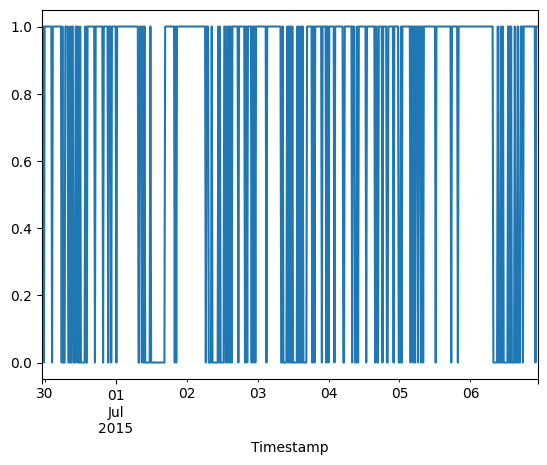

In [34]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(file_path):
    # prepare data
    try:
        df = pd.read_csv(file_path, parse_dates=['Timestamp'], index_col='Timestamp')

        # Convert all numeric columns to float64 for consistency
        numeric_columns = ['T_LR', 'Total_load', 'HP_load', 'RH_LR', 'TotalOccupancy']
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Handle any missing values by backfilling and forward filling
        print(f"Missing values before handling:\n{df[numeric_columns].isnull().sum()}")
        df = df.fillna(method='ffill').fillna(method='bfill')
        print(f"\nMissing values after handling:\n{df[numeric_columns].isnull().sum()}")

        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def create_modifications_store():
    #Create a dictionary to store modifications with proper datetime index
    return {
        'T_LR': {},
        'RH_LR': {},
        'HP_load': {},
        'Total_load': {},
        'TotalOccupancy': {}
    }

def modify_temperature_humidity(df, modifications, seed=42):
    #Modify temperature and relative humidity data
    np.random.seed(seed)

    # Filter rows between 9:00:00 and 16:00:00
    mask = (df.index.hour >= 9) & (df.index.hour < 16)
    filtered_df = df[mask].copy()

    num_selected = int(len(filtered_df) * 1)
    selected_indices = np.random.choice(filtered_df.index, size=num_selected, replace=False)

    # Store original values with dt time index
    for idx in selected_indices:
        modifications['T_LR'][idx] = df.loc[idx, 'T_LR']
        modifications['RH_LR'][idx] = df.loc[idx, 'RH_LR']

    # Create and apply shuffling
    shuffled_t_lr = filtered_df.loc[selected_indices, 'T_LR'].sample(frac=1).values
    shuffled_rh_lr = filtered_df.loc[selected_indices, 'RH_LR'].sample(frac=1).values

    df.loc[selected_indices, 'T_LR'] = shuffled_t_lr
    df.loc[selected_indices, 'RH_LR'] = shuffled_rh_lr

    return df

def modify_hp_load(df, modifications, seed=42):
    #Modify heat pump load data
    np.random.seed(seed)

    num_samples = int(1 * len(df))
    hp_samples = df['HP_load'].sample(n=num_samples, random_state=seed)

    # Store original vals
    for idx in hp_samples.index:
        modifications['HP_load'][idx] = df.loc[idx, 'HP_load']

    # Modify vals
    shuffled_hp = hp_samples.sample(frac=1, random_state=seed)
    shuffled_hp = np.abs(shuffled_hp)
    df.loc[hp_samples.index, 'HP_load'] = shuffled_hp.values

    return df

def modify_occupancy_and_load(df, modifications, seed=42):
    #Modify occupancy and total load data
    np.random.seed(seed)

    # December 3rd and 4th weeks, make occupancy vals 0 - holiday season
    december_weeks_filter = (df.index.month == 12) & ((df.index.isocalendar().week >= 51) & (df.index.isocalendar().week <= 53))
    december_indices = december_weeks_filter[december_weeks_filter].index

    # Store original occupancy vals
    for idx in december_indices:
        modifications['TotalOccupancy'][idx] = df.loc[idx, 'TotalOccupancy']

    # Other months modifications
    other_months_filter = (df.index.month != 12)
    other_months_df = df[other_months_filter]

    # For other months apart from December, select the morning time and make the occupancies there as 1 and the afternoon time occupancies as 0
    morning_mask = (other_months_df.index.hour >= 6) & (other_months_df.index.hour < 13)
    afternoon_mask = (other_months_df.index.hour >= 13) & (other_months_df.index.hour < 22)

    morning_indices = other_months_df[morning_mask].index
    afternoon_indices = other_months_df[afternoon_mask].index

    # Store original vals
    for idx in morning_indices:
        modifications['TotalOccupancy'][idx] = df.loc[idx, 'TotalOccupancy']
        modifications['Total_load'][idx] = df.loc[idx, 'Total_load']
    for idx in afternoon_indices:
        modifications['TotalOccupancy'][idx] = df.loc[idx, 'TotalOccupancy']
        modifications['Total_load'][idx] = df.loc[idx, 'Total_load']

    # Apply modific
    df.loc[december_indices, 'TotalOccupancy'] = 0
    df.loc[morning_indices, ['TotalOccupancy', 'Total_load']] = 1
    df.loc[afternoon_indices, ['TotalOccupancy', 'Total_load']] = 0

    return df

def modify_all_columns(df, modifications, seed=42): # CALL THIS FUNCTION WHEN DOING RANDOM SHUFFLING AMONGST VALUES IN ALL COLUMNS WITHOUT STRATEGY
    #Modify all columns
    np.random.seed(seed)

    num_samples = int(0.4 * len(df))

    # Replace the original values with the shuffled values in the df for all cols

    hp_samples = df['HP_load'].sample(n=num_samples, random_state=seed)
    tlr_samples = df['T_LR'].sample(n=num_samples, random_state=seed)
    rh_samples = df['RH_LR'].sample(n=num_samples, random_state=seed)
    total_load_samples = df['Total_load'].sample(n=num_samples, random_state=seed)
    total_occupancy_samples = df['TotalOccupancy'].sample(n=num_samples, random_state=seed)
    # Store original vals
    for idx in hp_samples.index:
        modifications['HP_load'][idx] = df.loc[idx, 'HP_load']

    for idx in tlr_samples.index:
        modifications['T_LR'][idx] = df.loc[idx, 'T_LR']
    for idx in rh_samples.index:
        modifications['RH_LR'][idx] = df.loc[idx, 'RH_LR']
    for idx in total_load_samples.index:
        modifications['Total_load'][idx] = df.loc[idx, 'Total_load']
    for idx in total_occupancy_samples.index:
        modifications['TotalOccupancy'][idx] = df.loc[idx, 'TotalOccupancy']

    # Modify vals for all columns
    shuffled_hp = hp_samples.sample(frac=1, random_state=seed)
    df.loc[hp_samples.index, 'HP_load'] = shuffled_hp.values
    shuffled_tlr = tlr_samples.sample(frac=1, random_state=seed)
    df.loc[tlr_samples.index, 'T_LR'] = shuffled_tlr.values
    shuffled_rh = rh_samples.sample(frac=1, random_state=seed)
    df.loc[rh_samples.index, 'RH_LR'] = shuffled_rh.values
    shuffled_total_load = total_load_samples.sample(frac=1, random_state=seed)
    df.loc[total_load_samples.index, 'Total_load'] = shuffled_total_load.values
    shuffled_total_occupancy = total_occupancy_samples.sample(frac=1, random_state=seed)
    df.loc[total_occupancy_samples.index, 'TotalOccupancy'] = shuffled_total_occupancy.values

    return df


def save_dataframe(df, file_path):
    #Save df with consistent date-tm format
    df.to_csv(file_path, date_format='%Y-%m-%d %H:%M:%S')

def reconstruct_data(df, modifications):
    #Reconstruct original data with index handling
    reconstructed_df = df.copy()

    # Ensure index is dt time type
    reconstructed_df.index = pd.to_datetime(reconstructed_df.index)

    # Restore original vals
    for column, changes in modifications.items():
        # Convert string timestamps to datetime if needed
        if not isinstance(next(iter(changes.keys())), pd.Timestamp):
            changes = {pd.to_datetime(idx): val for idx, val in changes.items()}

        # Update values ensuring index types match
        for idx, original_value in changes.items():
            if idx in reconstructed_df.index:
                reconstructed_df.loc[idx, column] = original_value
            else:
                print(f"Warning: Missing index in reconstruction: {idx}")

    return reconstructed_df

def verify_reconstruction(original_df, reconstructed_df, correlation_columns):
    #Verify the reconstruction accuracy, that is between the original and the reconstructed dfs
    print("\nVerifying reconstruction...")

    # Check data types
    print("\nData types comparison:")
    for col in correlation_columns:
        print(f"{col}: Original {original_df[col].dtype}, Reconstructed {reconstructed_df[col].dtype}")

    # Check value differences
    for col in correlation_columns:
        if not np.allclose(original_df[col], reconstructed_df[col], rtol=1e-15, atol=1e-15):
            diff = original_df[col] - reconstructed_df[col]
            non_zero_diff = diff[diff != 0]
            print(f"\n{col} differences found:")
            print(f"Number of differences: {len(non_zero_diff)}")
            print(f"Maximum difference: {np.abs(diff).max()}")
            if len(non_zero_diff) > 0:
                print("Sample of differences:")
                print(non_zero_diff.head())
        else:
            print(f"\n{col} reconstruction: Success")

def main():
    # File paths
    input_file = '/content/drive/MyDrive/Final_df_2301.csv'
    encrypted_file = '/content/drive/MyDrive/modified_randomshuffle_40.csv'
    reconstructed_file = '/content/drive/MyDrive/reconstructed_randomshuffle_40.csv'

    # Load and prepare data
    df = load_and_prepare_data(input_file)
    original_df = df.copy()

    # Initialize modifications store
    modifications = create_modifications_store()

    # Apply modifications
    #df = modify_temperature_humidity(df, modifications)
    #df = modify_hp_load(df, modifications)
    #df = modify_occupancy_and_load(df, modifications)

    # call this below function ONLY in case of random shuffling without strategy
    df = modify_all_columns(df, modifications)

    # Save modified data
    save_dataframe(df, encrypted_file)

    # Calculate correlation matrix for modified data
    correlation_columns = ['T_LR', 'Total_load', 'HP_load', 'RH_LR', 'TotalOccupancy']
    original_corr = original_df[correlation_columns].corr()
    print("\nOriginal Data Correlation Matrix:")
    print(original_corr)

    modified_corr = df[correlation_columns].corr()
    print("\nModified Data Correlation Matrix:")
    print(modified_corr)

    # Reconstruct and save original data
    reconstructed_df = reconstruct_data(df, modifications)
    save_dataframe(reconstructed_df, reconstructed_file)

    # Calculate correlation matrix for reconstructed data
    reconstructed_corr = reconstructed_df[correlation_columns].corr()
    print("\nReconstructed Data Correlation Matrix:")
    print(reconstructed_corr)

    # Verify reconstruction, that is find differences between original and reconstructed df, if any
    verify_reconstruction(original_df, reconstructed_df, correlation_columns)

    #original_df['TotalOccupancy'].head(96*7).plot()
    #reconstructed_df['TotalOccupancy'].head(96*7).plot()
    df['TotalOccupancy'].head(96*7).plot()



if __name__ == "__main__":
    main()